# Comparative Analysis
In this notebook, we compare ClaSS with different parameter settings.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import pandas as pd
import daproli as dp

import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import Orange
import sys
sys.path.append("../../")

from tqdm import tqdm

Let's choose a score for evaluation (F1 or Covering).

In [3]:
eval_score = "covering_score"

Let's load the scores from the different methods.

In [4]:
sample_sizes = ("None", 10, 100, 1_000, 10_000)
methods = list()

for sample_size in sample_sizes:
    candidate_name = f"{sample_size}-sample_size"
    methods.append((candidate_name, f"{candidate_name}.csv"))

for idx, (name, file_name) in enumerate(methods):
    methods[idx] = name, pd.read_csv(f"../../experiments/sample_size/{file_name}")
    
df_scores = pd.DataFrame()

for name, df in methods:
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]
    
df_scores

,dataset,None-sample_size,10-sample_size,100-sample_size,1000-sample_size,10000-sample_size
0,DodgerLoopDay,1.000,1.000,1.000,1.000,0.758
1,EEGRat,0.885,0.500,0.500,0.885,0.654
2,EEGRat2,0.848,0.500,0.500,0.739,0.475
3,FaceFour,0.898,0.281,0.281,0.741,0.384
4,GrandMalSeizures2,0.411,0.508,0.508,0.761,0.300
5,GreatBarbet1,0.877,0.355,0.355,0.877,0.319
6,Herring,1.000,1.000,1.000,1.000,0.128
7,InlineSkate,0.686,0.358,0.358,0.358,0.598
8,InsectEPG1,0.287,0.653,0.653,0.751,0.124
9,MelbournePedestrian,0.987,0.149,0.149,0.943,0.443


Let's calculate the mean/std score.

In [5]:
df_scores.mean(axis=0).round(3)

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_2448/2219294936.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_scores.mean(axis=0).round(3)


None-sample_size     0.784
10-sample_size       0.462
100-sample_size      0.462
1000-sample_size     0.791
10000-sample_size    0.407
dtype: float64

In [6]:
df_scores.std(axis=0).round(3)

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_2448/1084607075.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_scores.std(axis=0).round(3)


None-sample_size     0.228
10-sample_size       0.241
100-sample_size      0.241
1000-sample_size     0.156
10000-sample_size    0.164
dtype: float64

Let's compute the wins per method.

In [7]:
ranks = df_scores.rank(1, method = 'min', ascending=False)
means = np.array(ranks.mean(axis=0))

In [8]:
for mean, name in zip(means, df_scores.columns[1:]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 5)}")

None-sample_size:wins=17 rank=1.57143
10-sample_size:wins=3 rank=2.85714
100-sample_size:wins=3 rank=2.85714
1000-sample_size:wins=11 rank=1.52381
10000-sample_size:wins=0 rank=4.09524


Let's plot and output the ranks.

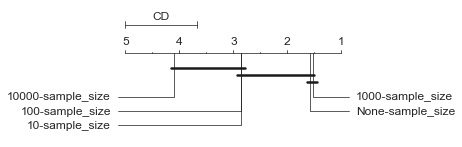

In [9]:
cd = Orange.evaluation.scoring.compute_CD(means, df_scores.shape[0])
Orange.evaluation.scoring.graph_ranks(means, df_scores.columns[1:], cd=cd, reverse=True, width=5, filename="../../figures/cd_ablation_sample_size.pdf")

Let's compute wins/losses against ClaSP.

In [10]:
selection = "1000-sample_size"

for rival in df_scores.columns[1:]:
    if rival == selection: continue
    
    df_pair = df_scores[[selection, rival]]
    pair_ranks = df_pair.rank(1, method = 'min', ascending=False)
    
    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]
    
    assert wins + losses + ties == pair_ranks.shape[0]
    
    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

1000-sample_size vs None-sample_size: (wins/ties/losses): 4/7/10
1000-sample_size vs 10-sample_size: (wins/ties/losses): 16/5/0
1000-sample_size vs 100-sample_size: (wins/ties/losses): 16/5/0
1000-sample_size vs 10000-sample_size: (wins/ties/losses): 20/0/1


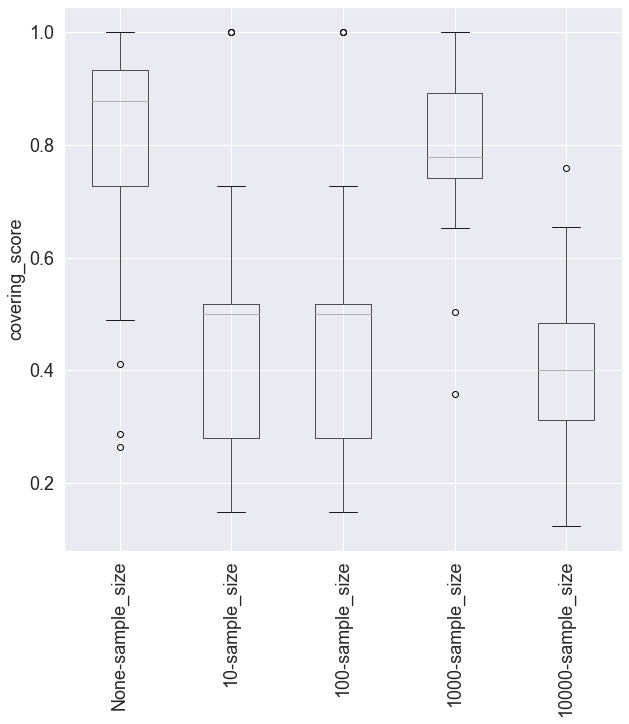

In [11]:
fontsize = 18
_, ax = plt.subplots(figsize=(10,10))

df_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel(eval_score, fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
    
plt.savefig("../../figures/bp_ablation_sample_size.pdf", bbox_inches="tight") 